In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

In [25]:
from sklearn.metrics import r2_score
import random

In [9]:
stats_t1d = pd.read_pickle('stats_t1d_dec.pkl')

# Pretraining

In [15]:
# for pretraining, choose 7 out of 9 datasets (all datasets except JDRF and Sence)

stats_t1d_population_train = stats_t1d[(stats_t1d['Dataset']!='dlcp3') & (stats_t1d['Dataset']!='replacebg')][['Means', 'SD', 'Skewness', 'Kurtosis', 'StandardizedFifthMoment', 'HbA1cTestRes']]

In [16]:
# for testing the pretrained model (population training)

stats_t1d_population_test = stats_t1d[(stats_t1d['Dataset']=='dlcp3') | (stats_t1d['Dataset']=='replacebg')][['Means', 'SD', 'Skewness', 'Kurtosis', 'StandardizedFifthMoment', 'HbA1cTestRes']]

In [17]:
stats_t1d_population_train = stats_t1d_population_train.dropna()
stats_t1d_population_test = stats_t1d_population_test.dropna()

In [23]:
stats_t1d_population_train_x = stats_t1d_population_train[['Means', 'SD', 'Skewness', 'Kurtosis', 'StandardizedFifthMoment']]
stats_t1d_population_train_y = stats_t1d_population_train['HbA1cTestRes']
stats_t1d_population_test_x = stats_t1d_population_test[['Means', 'SD', 'Skewness', 'Kurtosis', 'StandardizedFifthMoment']]
stats_t1d_population_test_y = stats_t1d_population_test['HbA1cTestRes']
train_X_tensor = torch.tensor(stats_t1d_population_train_x.values, dtype=torch.float32)
train_y_tensor = torch.tensor(stats_t1d_population_train_y.values, dtype=torch.float32).unsqueeze(1)
test_X_tensor = torch.tensor(stats_t1d_population_test_x.values, dtype=torch.float32)
test_y_tensor = torch.tensor(stats_t1d_population_test_y.values, dtype=torch.float32).unsqueeze(1)

In [40]:
class nnPopulation(nn.Module):
    def __init__(self, numFeatures, hidden_layer_neurons, dropout_rate=0, actFunct=nn.ReLU):
        super(nnPopulation, self).__init__()
        layers = []
        layer_input = numFeatures
        for hidden_layer_neuron in hidden_layer_neurons:
            fc_temp = nn.Linear(layer_input, hidden_layer_neuron)
            actFunc_temp = actFunct()
            dropout_temp = nn.Dropout(dropout_rate)
            if dropout_rate>0:
                layers.append(fc_temp)
                layers.append(actFunc_temp)
                layers.append(dropout_temp)
            else:
                layers.append(fc_temp)
                layers.append(actFunc_temp)
            
            layer_input = hidden_layer_neuron

        last_layer = nn.Linear(hidden_layer_neurons[-1], 1)
        layers.append(last_layer)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        y = self.model(x)
        return y

In [27]:
def train_test(model, train_X, train_y, test_X, test_y, epochs=100, learning_rate=1e-3, weightDecay=0):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weightDecay)
    # Model training
    train_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_X)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
        if epoch%50==0:
            train_losses.append(loss.item())

    # Prediction
    model.eval()
    with torch.no_grad():
        train_pred = model(train_X)
        test_pred = model(test_X)
        
    r2_train = r2_score(train_pred.numpy(), train_y.numpy())
    r2_test = r2_score(test_pred.numpy(), test_y.numpy())

    
    return r2_train, r2_test, train_losses

In [28]:
numFeatures = stats_t1d_population_train_x.shape[1]

In [29]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [117]:
set_seed()
# Save each experiments' results
experiment_results = []

# Hyperparameters
hidden_layer_configs = [[8, 4], [16, 8, 4], [32, 16, 8]]
activation_functions_configs = [nn.ReLU, nn.Tanh, nn.Sigmoid]
weight_decays_configs = [1e-5, 1e-4, 1e-3]

# Run experiments
for hidden_layers in hidden_layer_configs:
    for act_funct in activation_functions_configs:
        for weight_decay in weight_decays_configs:
            model_population = nnPopulation(
                numFeatures=numFeatures,
                hidden_layer_neurons=hidden_layers,
                actFunct=act_funct
            )
            
            # Train and evaluate the model
            train_r2, test_r2, train_losses = train_test(
                model_population,
                train_X_tensor,
                train_y_tensor,
                test_X_tensor,
                test_y_tensor,
                epochs=500,
                weightDecay=weight_decay
            )
            
            # Store results
            experiment_results.append((hidden_layers, act_funct.__name__, weight_decay, train_r2, test_r2, train_losses))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [37]:
epoches = np.arange(50, 501, 50)

Experiment Results
Hidden Layer: [8, 4], activation function: ReLU, Weight Decay: 1e-05
Train R^2: 0.6875309348106384, Test R^2: 0.4933236837387085


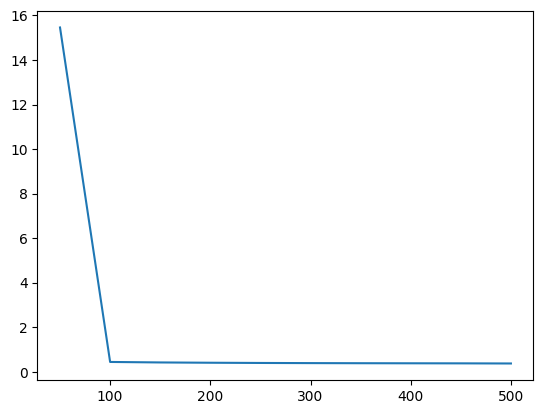

Hidden Layer: [8, 4], activation function: ReLU, Weight Decay: 0.0001
Train R^2: -243050624.0, Test R^2: -1.174492629958656e+16


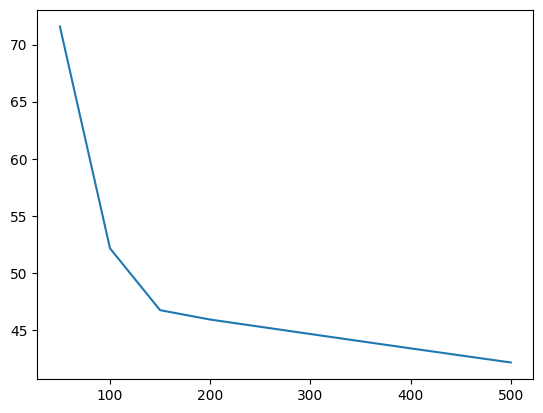

Hidden Layer: [8, 4], activation function: ReLU, Weight Decay: 0.001
Train R^2: -1.2547916606472192e+16, Test R^2: -1.2606761953394688e+16


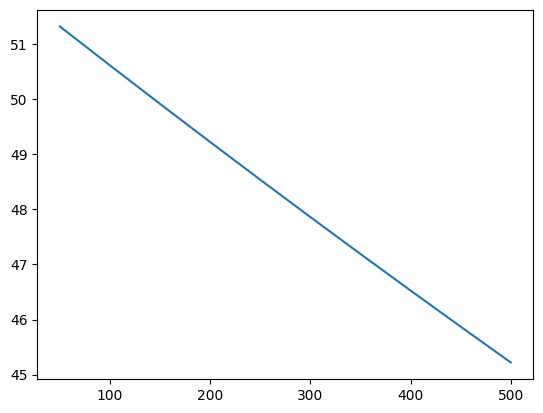

Hidden Layer: [8, 4], activation function: Tanh, Weight Decay: 1e-05
Train R^2: -20139.6484375, Test R^2: -295722.5


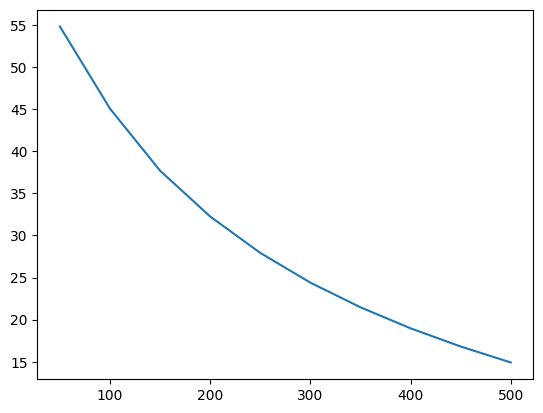

Hidden Layer: [8, 4], activation function: Tanh, Weight Decay: 0.0001
Train R^2: -251433.484375, Test R^2: -1677154.625


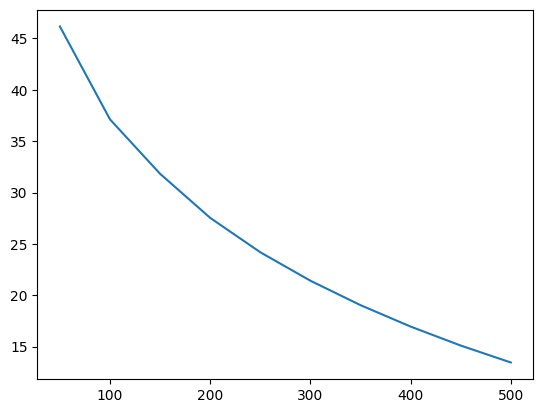

Hidden Layer: [8, 4], activation function: Tanh, Weight Decay: 0.001
Train R^2: -184184.0, Test R^2: -793171.25


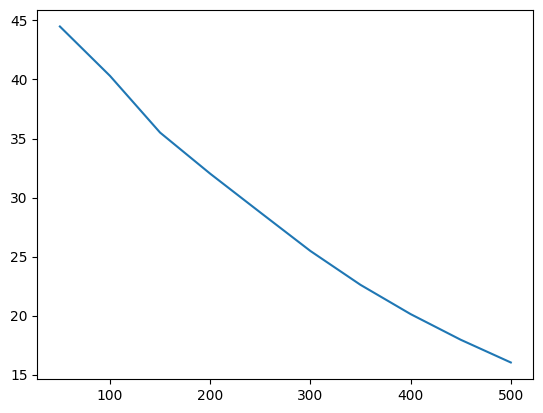

Hidden Layer: [8, 4], activation function: Sigmoid, Weight Decay: 1e-05
Train R^2: -19393424.0, Test R^2: -307509329920.0


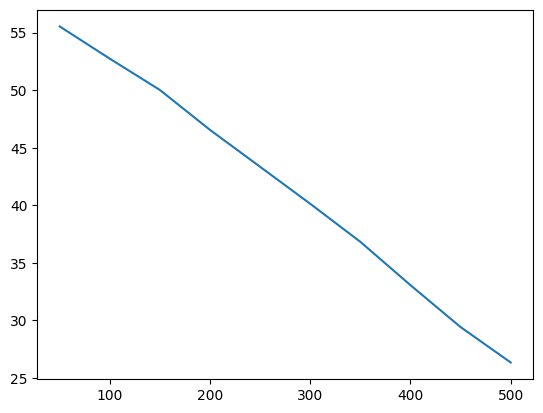

Hidden Layer: [8, 4], activation function: Sigmoid, Weight Decay: 0.0001
Train R^2: -7464412.0, Test R^2: -30757780.0


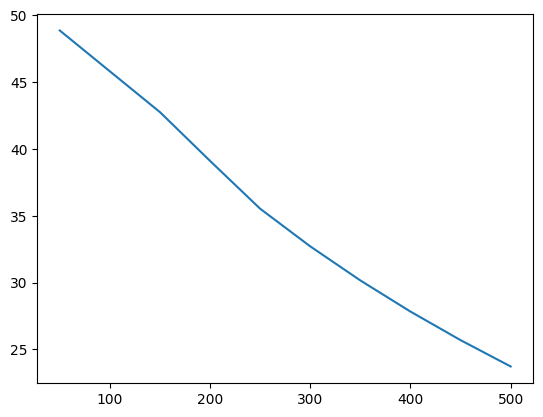

Hidden Layer: [8, 4], activation function: Sigmoid, Weight Decay: 0.001
Train R^2: -22383284.0, Test R^2: -148694176.0


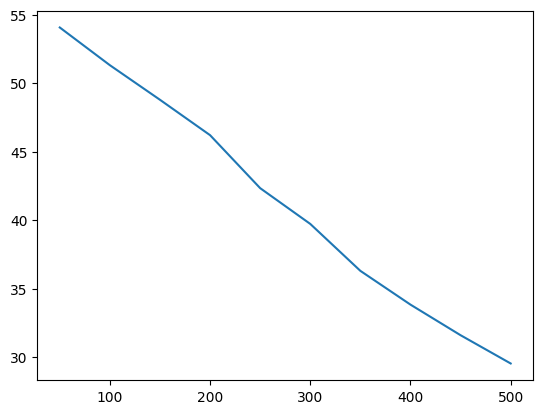

Hidden Layer: [16, 8, 4], activation function: ReLU, Weight Decay: 1e-05
Train R^2: 0.7069597244262695, Test R^2: 0.49780458211898804


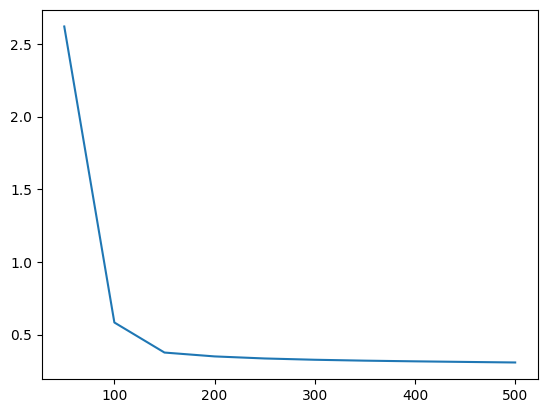

Hidden Layer: [16, 8, 4], activation function: ReLU, Weight Decay: 0.0001
Train R^2: 0.6998205780982971, Test R^2: 0.5083087682723999


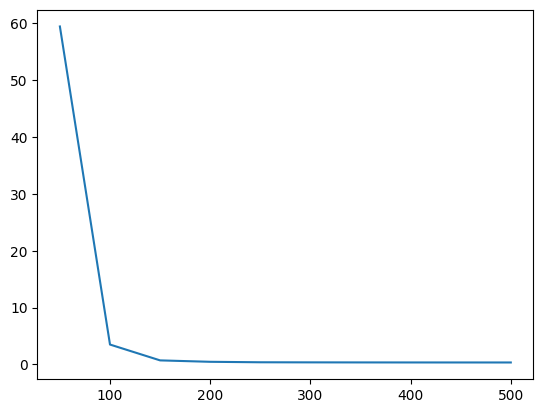

Hidden Layer: [16, 8, 4], activation function: ReLU, Weight Decay: 0.001
Train R^2: 0.7011417150497437, Test R^2: 0.5051482915878296


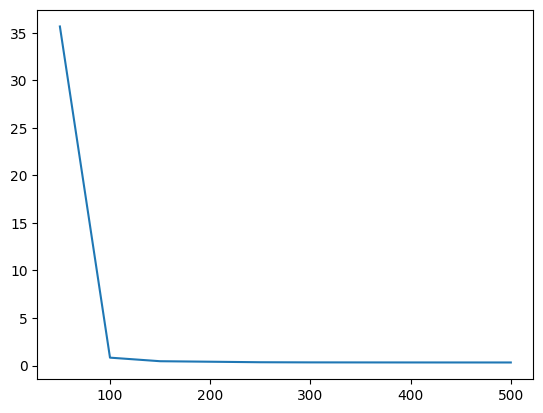

Hidden Layer: [16, 8, 4], activation function: Tanh, Weight Decay: 1e-05
Train R^2: -83825.5703125, Test R^2: -209604992.0


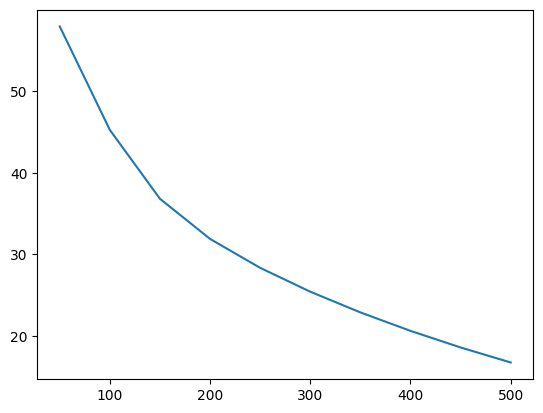

Hidden Layer: [16, 8, 4], activation function: Tanh, Weight Decay: 0.0001
Train R^2: -3090.77099609375, Test R^2: -10742624.0


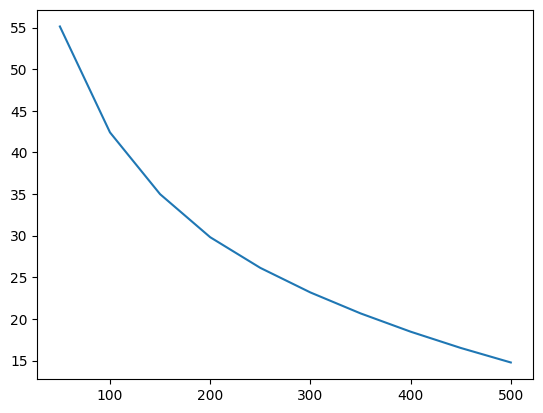

Hidden Layer: [16, 8, 4], activation function: Tanh, Weight Decay: 0.001
Train R^2: -649796864.0, Test R^2: -21288642936832.0


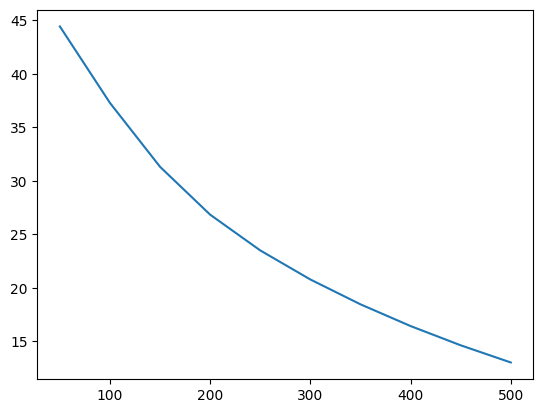

Hidden Layer: [16, 8, 4], activation function: Sigmoid, Weight Decay: 1e-05
Train R^2: -123396300800.0, Test R^2: -918220898304.0


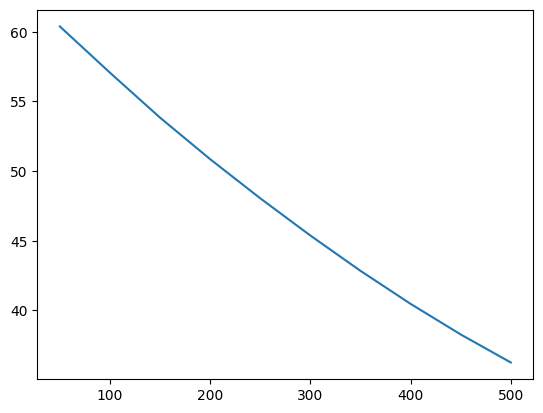

Hidden Layer: [16, 8, 4], activation function: Sigmoid, Weight Decay: 0.0001
Train R^2: -623382272.0, Test R^2: -2109064448.0


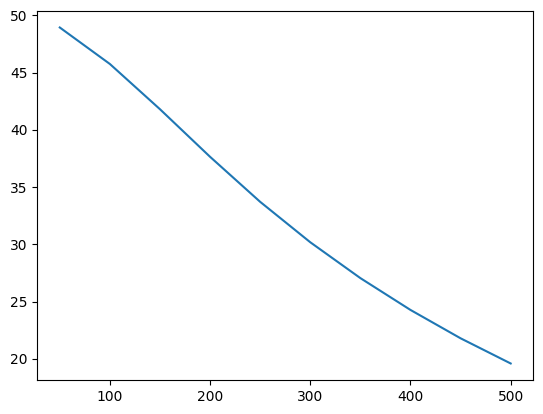

Hidden Layer: [16, 8, 4], activation function: Sigmoid, Weight Decay: 0.001
Train R^2: -671305856.0, Test R^2: -322518712320.0


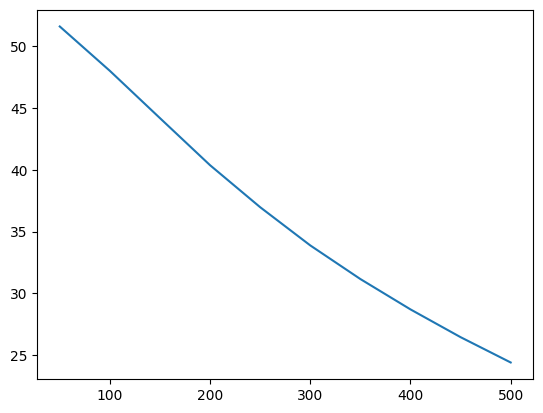

Hidden Layer: [32, 16, 8], activation function: ReLU, Weight Decay: 1e-05
Train R^2: 0.6998567581176758, Test R^2: 0.4950627088546753


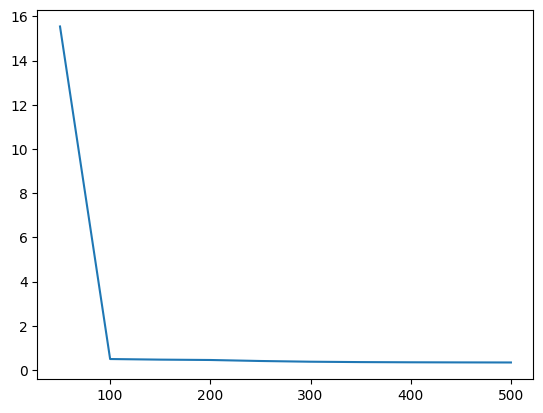

Hidden Layer: [32, 16, 8], activation function: ReLU, Weight Decay: 0.0001
Train R^2: 0.7025606036186218, Test R^2: 0.49889832735061646


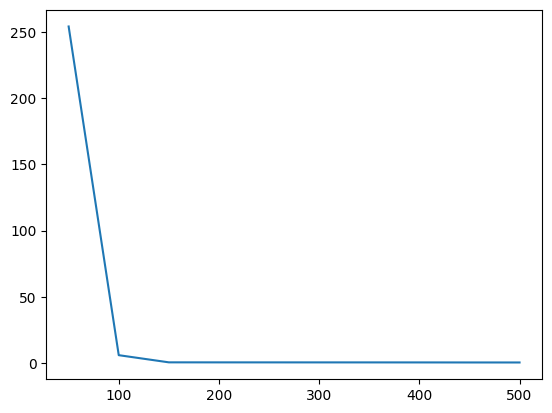

Hidden Layer: [32, 16, 8], activation function: ReLU, Weight Decay: 0.001
Train R^2: 0.6970241069793701, Test R^2: 0.5072866678237915


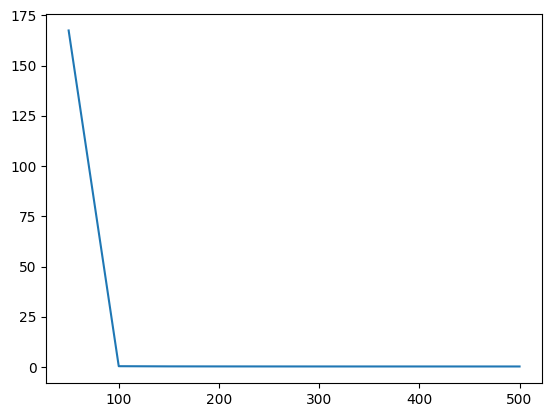

Hidden Layer: [32, 16, 8], activation function: Tanh, Weight Decay: 1e-05
Train R^2: -264854.9375, Test R^2: -170859072.0


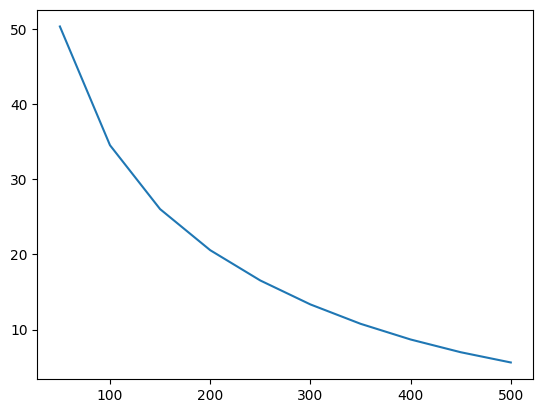

Hidden Layer: [32, 16, 8], activation function: Tanh, Weight Decay: 0.0001
Train R^2: -84342.4140625, Test R^2: -75866088.0


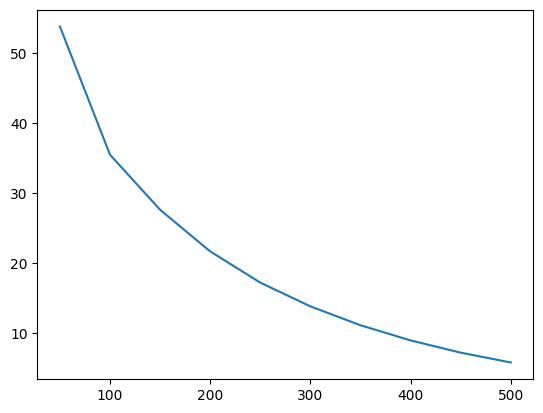

Hidden Layer: [32, 16, 8], activation function: Tanh, Weight Decay: 0.001
Train R^2: -456564.96875, Test R^2: -30649260.0


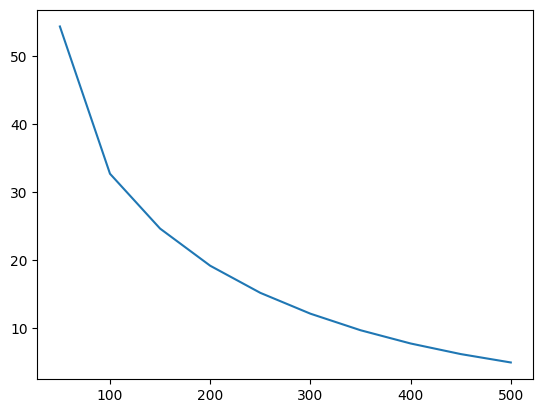

Hidden Layer: [32, 16, 8], activation function: Sigmoid, Weight Decay: 1e-05
Train R^2: -6600507392.0, Test R^2: -26825510912.0


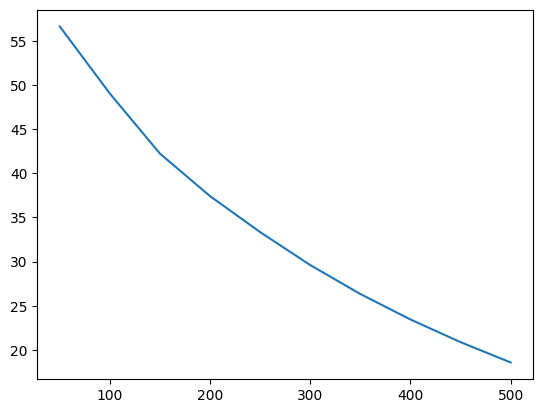

Hidden Layer: [32, 16, 8], activation function: Sigmoid, Weight Decay: 0.0001
Train R^2: -3168503040.0, Test R^2: -7937364992.0


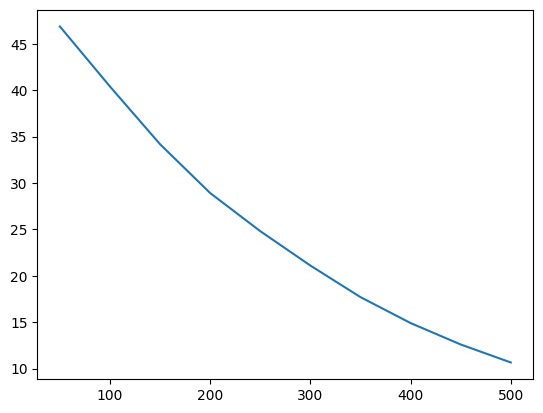

Hidden Layer: [32, 16, 8], activation function: Sigmoid, Weight Decay: 0.001
Train R^2: -5481155584.0, Test R^2: -57930534912.0


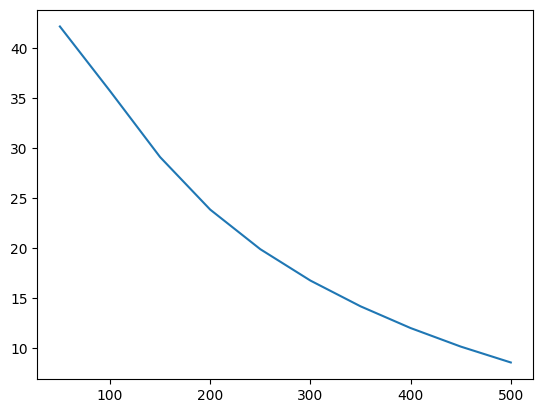

Best Configurations
Hidden Layer: [16, 8, 4], activation function: ReLU, Weight Decay: 0.0001
Train R^2: 0.6998205780982971, Test R^2: 0.5083087682723999
Hidden Layer: [32, 16, 8], activation function: ReLU, Weight Decay: 0.001
Train R^2: 0.6970241069793701, Test R^2: 0.5072866678237915
Hidden Layer: [16, 8, 4], activation function: ReLU, Weight Decay: 0.001
Train R^2: 0.7011417150497437, Test R^2: 0.5051482915878296
Hidden Layer: [32, 16, 8], activation function: ReLU, Weight Decay: 0.0001
Train R^2: 0.7025606036186218, Test R^2: 0.49889832735061646
Hidden Layer: [16, 8, 4], activation function: ReLU, Weight Decay: 1e-05
Train R^2: 0.7069597244262695, Test R^2: 0.49780458211898804
Hidden Layer: [32, 16, 8], activation function: ReLU, Weight Decay: 1e-05
Train R^2: 0.6998567581176758, Test R^2: 0.4950627088546753
Hidden Layer: [8, 4], activation function: ReLU, Weight Decay: 1e-05
Train R^2: 0.6875309348106384, Test R^2: 0.4933236837387085
Hidden Layer: [8, 4], activation function: Tan

In [118]:
print("Experiment Results")
for hidden_layers, act_funct, weight_decay, train_r2, test_r2, train_losses in experiment_results:
    print('Hidden Layer: '+ str(hidden_layers) + ', activation function: ' + str(act_funct) + ', Weight Decay: '+ str(weight_decay))
    print('Train R^2: ' + str(train_r2) + ', Test R^2: ' + str(test_r2))
    plt.plot(epoches, train_losses)
    plt.show()

# Sort results by test R^2 for analysis
sorted_results = sorted(experiment_results, key=lambda x: x[4], reverse=True)

print('Best Configurations')
for hidden_layers, act_funct, weight_decay, train_r2, test_r2, train_losses in sorted_results[:20]:
    print('Hidden Layer: '+ str(hidden_layers) + ', activation function: ' + str(act_funct) + ', Weight Decay: '+ str(weight_decay))
    print('Train R^2: ' + str(train_r2) + ', Test R^2: ' + str(test_r2))

Hidden Layer: [16, 8, 4], activation function: ReLU, Weight Decay: 1e-05
Train R^2: 0.7069597244262695, Test R^2: 0.49780458211898804
Hidden Layer: [32, 16, 8], activation function: ReLU, Weight Decay: 1e-05
Train R^2: 0.6998567581176758, Test R^2: 0.4950627088546753
Hidden Layer: [8, 4], activation function: ReLU, Weight Decay: 1e-05
Train R^2: 0.6875309348106384, Test R^2: 0.4933236837387085
Hidden Layer: [8, 4], activation function: Tanh, Weight Decay: 1e-05
Train R^2: -20139.6484375, Test R^2: -295722.5
Hidden Layer: [32, 16, 8], activation function: Tanh, Weight Decay: 1e-05
Train R^2: -264854.9375, Test R^2: -170859072.0
Hidden Layer: [16, 8, 4], activation function: Tanh, Weight Decay: 1e-05
Train R^2: -83825.5703125, Test R^2: -209604992.0
Hidden Layer: [32, 16, 8], activation function: Sigmoid, Weight Decay: 1e-05
Train R^2: -6600507392.0, Test R^2: -26825510912.0


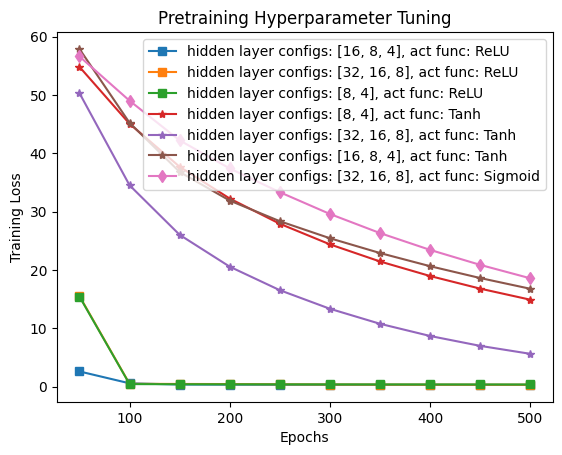

In [120]:
for hidden_layers, act_funct, weight_decay, train_r2, test_r2, train_losses in sorted_results[:20]:
    if weight_decay>1e-5:
        continue
    print('Hidden Layer: '+ str(hidden_layers) + ', activation function: ' + str(act_funct) + ', Weight Decay: '+ str(weight_decay))
    print('Train R^2: ' + str(train_r2) + ', Test R^2: ' + str(test_r2))
    if act_funct=='ReLU':
        marker = 's'
    elif act_funct=='Tanh':
        marker = '*'
    else:
        marker = 'd'
    plt.plot(epoches, train_losses, label='hidden layer configs: '+str(hidden_layers)+', act func: '+str(act_funct), marker = marker)

plt.legend()
plt.title('Pretraining Hyperparameter Tuning')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

In [56]:
# I choose
actFunct = nn.ReLU
hidden_layer_config = [8,4]
weight_decay = 1e-5

In [57]:
set_seed()

model_population = nnPopulation(numFeatures=numFeatures, hidden_layer_neurons=hidden_layer_config, actFunct=actFunct)
    
train_r2, test_r2, training_loss = train_test(model_population, train_X_tensor, train_y_tensor, test_X_tensor, test_y_tensor, epochs=500, weightDecay=weight_decay)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [61]:
train_r2

0.6875309348106384

In [60]:
test_r2

0.4933236837387085

# Transfer Learning

In [85]:
# testing the population
stats_t1d_individual = stats_t1d[(stats_t1d['Dataset']=='dlcp3') | (stats_t1d['Dataset']=='replacebg')][['PtID', 'Visit', 'Means', 'SD', 'Skewness', 'Kurtosis', 'StandardizedFifthMoment', 'HbA1cTestRes']]

In [86]:
stats_t1d_individual = stats_t1d_individual.dropna()

In [87]:
stats_t1d_individual.shape

(980, 8)

In [88]:
stats_t1d_individual['Visit'].unique()

array(['13-Week', '26-Week', 'Randomization', 'Week 13 Visit',
       'Week 26 Visit'], dtype=object)

In [89]:
stats_t1d_individual['Visit'] = stats_t1d_individual['Visit'].apply(lambda x: '13-Week' if (x=='Week 13 Visit') else 
                                                                                            ('26-Week' if (x=='Week 26 Visit') else x))

In [90]:
stats_t1d_individual = stats_t1d_individual[stats_t1d_individual['Visit']!='Randomization']

In [91]:
# We must assure that the individuals have the data for both first 13 weeks and the second 13 weeks CGM data
visit_counts = stats_t1d_individual.groupby('PtID').count()['Visit']
single_visit_ptids = visit_counts[visit_counts == 1].index
# Remove rows where PtID has only one visit
stats_t1d_individual = stats_t1d_individual[~stats_t1d_individual['PtID'].isin(single_visit_ptids)]

In [103]:
week_13_index = stats_t1d_individual["Visit"] == "13-Week"
week_26_index = stats_t1d_individual["Visit"] == "26-Week"

# Week 13
transfer_learning_X_train = stats_t1d_individual[week_13_index].drop(columns=["PtID", "Visit", "HbA1cTestRes"]).values
transfer_learning_y_train = stats_t1d_individual[week_13_index]["HbA1cTestRes"].values

# Extract week 26 features and labels
transfer_learning_X_test = stats_t1d_individual[week_26_index].drop(columns=["PtID", "Visit", "HbA1cTestRes"]).values
transfer_learning_y_test = stats_t1d_individual[week_26_index]["HbA1cTestRes"].values

In [104]:
print(transfer_learning_X_train.shape)
print(transfer_learning_X_test.shape)

(381, 5)
(381, 5)


In [106]:
def fine_tune(
    model_population,  # Pre-trained population model
    individual_model,  # Individual model to fine-tune
    train_X,
    train_y,
    epochs=100,
    learning_rate=0.01,
    lambda_reg=0.1,     # Regularization coefficient
    unfreeze_layer=4
):
    criterion = nn.MSELoss()

    # Load population weights into the individual model
    individual_model.load_state_dict(model_population.state_dict())

    if unfreeze_layer<10:
        layer_to_unfreeze = "model."+str(unfreeze_layer)
        # Freeze all layers except the last one
        for name, param in individual_model.named_parameters():
            # Only allow gradients for parameters in the last layer
            if layer_to_unfreeze not in name:
                param.requires_grad = False
    else:
        #24, 40, 20
        
        layer_to_unfreeze1 = "model."+str(unfreeze_layer)[0]
        layer_to_unfreeze2 = "model."+str(unfreeze_layer)[1]
        layers_to_unfreeze = [layer_to_unfreeze1, layer_to_unfreeze2]
        
        for name, param in individual_model.named_parameters():
            if not any(layer in name for layer in layers_to_unfreeze):
                param.requires_grad = False

    # Get the population model parameters
    population_state_dict = model_population.state_dict()

    # Optimizer for trainable parameters
    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, individual_model.parameters()),
        lr=learning_rate
    )

    for epoch in range(epochs):
        individual_model.train()
        outputs = individual_model(train_X)
        mse_loss = criterion(outputs, train_y)  # MSE loss

        # Regularization loss
        reg_loss = 0
        for name, param in individual_model.named_parameters():
            if name in population_state_dict and param.requires_grad:  # Only for trainable params
                reg_loss += torch.sum((param - population_state_dict[name]) ** 2)
        reg_loss = lambda_reg * reg_loss

        # Total loss
        total_loss = mse_loss + reg_loss

        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    return individual_model

In [110]:
# Hyperparameter search space
learning_rates = [0.0005, 0.001]
regularization_strengths = [3, 6, 9, 12]
unfreeze_layers_list = [0, 2, 4, 24, 40, 20]
epochs = 500

# Store predictions and targets for all individuals
all_predictions = []
all_targets = []

# Hyperparameter tuning for all individuals
for i, (week_12_X, week_12_y, week_24_X, week_24_y) in enumerate(
    zip(transfer_learning_X_train, transfer_learning_y_train, transfer_learning_X_test, transfer_learning_y_test)
):
    print('Fine-tuning for individual '+ str(i + 1))

    # Prepare tensors for training and testing
    week_12_X_tensor = torch.tensor(week_12_X, dtype=torch.float32)
    week_12_y_tensor = torch.tensor([week_12_y], dtype=torch.float32).unsqueeze(1)
    week_24_X_tensor = torch.tensor(week_24_X, dtype=torch.float32)
    week_24_y_tensor = torch.tensor([week_24_y], dtype=torch.float32).unsqueeze(1)

    best_model = None
    best_params = None
    best_prediction = None

    # Hyperparameter tuning loop
    for lr, lambda_reg, unfreeze_layer in itertools.product(learning_rates, regularization_strengths, unfreeze_layers_list):
        set_seed()

        # Initialize individual model
        model_individual = nnPopulation(numFeatures, hidden_layer_config, actFunct=nn.ReLU)
        model_individual.load_state_dict(model_population.state_dict())

        # Fine-tune the model
        try:
            fine_tuned_model = fine_tune(
                model_population=model_population,
                individual_model=model_individual,
                train_X=week_12_X_tensor,
                train_y=week_12_y_tensor,
                epochs=epochs,
                learning_rate=lr,
                lambda_reg=lambda_reg,
                unfreeze_layer=unfreeze_layer
            )
        except Exception as e:
            print(f"Error during fine-tuning: {e}")
            continue

        # Predict on week 26 data
        fine_tuned_model.eval()
        with torch.no_grad():
            week_24_preds = fine_tuned_model(week_24_X_tensor).item()

        # Update best prediction based on loss
        mse_loss = ((week_24_preds - week_24_y_tensor.item()) ** 2)
        if best_model is None or mse_loss < best_params.get("mse_loss", float("inf")):
            best_model = fine_tuned_model
            best_params = {"lr": lr, "lambda_reg": lambda_reg, "epochs": epochs, "unfreeze_layer":unfreeze_layer, "mse_loss": mse_loss}
            best_prediction = week_24_preds

    # Store the best prediction and target for this individual
    all_predictions.append(best_prediction)
    all_targets.append(week_24_y_tensor.item())

    print('Individual ' + str(i+1) + 'best prediction: ' + str(best_prediction) + ', target: ' + str(week_24_y_tensor.item()))
    print('Best hyperparameters: '+ str(best_params))

# Compute aggregated R^2 across all individuals
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
overall_r2 = r2_score(all_targets, all_predictions)

print('Overall R^2 for Fine-Tuned Models: ' + str(overall_r2))

Fine-tuning for individual 1


/Users/bariqfirmansyah/miniforge3/envs/py311/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Individual 1best prediction: 7.693517684936523, target: 7.699999809265137
Best hyperparameters: {'lr': 0.001, 'lambda_reg': 3, 'epochs': 500, 'unfreeze_layer': 20, 'mse_loss': 4.201793581160018e-05}
Fine-tuning for individual 2
Individual 2best prediction: 7.906829833984375, target: 7.900000095367432
Best hyperparameters: {'lr': 0.0005, 'lambda_reg': 9, 'epochs': 500, 'unfreeze_layer': 20, 'mse_loss': 4.664532957576739e-05}
Fine-tuning for individual 3
Individual 3best prediction: 6.585803508758545, target: 6.599999904632568
Best hyperparameters: {'lr': 0.001, 'lambda_reg': 6, 'epochs': 500, 'unfreeze_layer': 20, 'mse_loss': 0.00020153765581198968}
Fine-tuning for individual 4
Individual 4best prediction: 6.436092853546143, target: 6.199999809265137
Best hyperparameters: {'lr': 0.001, 'lambda_reg': 9, 'epochs': 500, 'unfreeze_layer': 0, 'mse_loss': 0.055739925557872994}
Fine-tuning for individual 5
Individual 5best prediction: 7.39320182800293, target: 7.400000095367432
Best hyperparam

In [111]:
np.mean((all_predictions-all_targets)**2)

np.float64(0.01312225318005692)

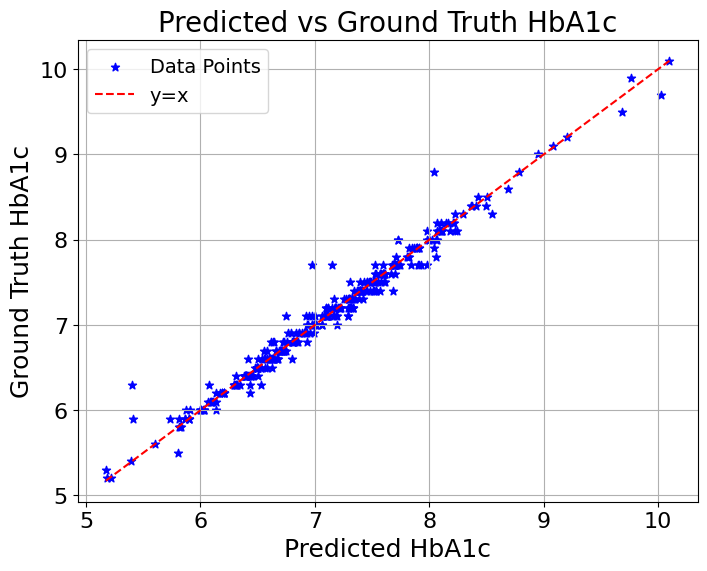

In [112]:
plt.figure(figsize=(8, 6))
plt.scatter(all_predictions, all_targets, color='blue', label='Data Points', marker='*')
plt.plot(
    [min(all_predictions.min(), all_targets.min()), max(all_predictions.max(), all_targets.max())],
    [min(all_predictions.min(), all_targets.min()), max(all_predictions.max(), all_targets.max())],
    color='red',
    linestyle='--',
    label='y=x'
)
plt.xlabel('Predicted HbA1c', fontsize=18)
plt.ylabel('Ground Truth HbA1c', fontsize=18)
plt.title('Predicted vs Ground Truth HbA1c', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()